# Simple Ordinary Differential Equation 

We will solve a simple ode:

$$
\frac{du}{dx} = 2x, \qquad \text{where} \quad  x \in [0,1],
$$

with the initial condition:

$$
u(0) = 1.
$$

The exact solution is:

$$
u(x) = 1 + x^2.
$$

## Implementation and Training

First, we import the Torch, NumPy, Matplotlib and DateTime libraries:

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import datetime

We define the exact solution function and plot it:

Text(0, 0.5, '$u(x)$')

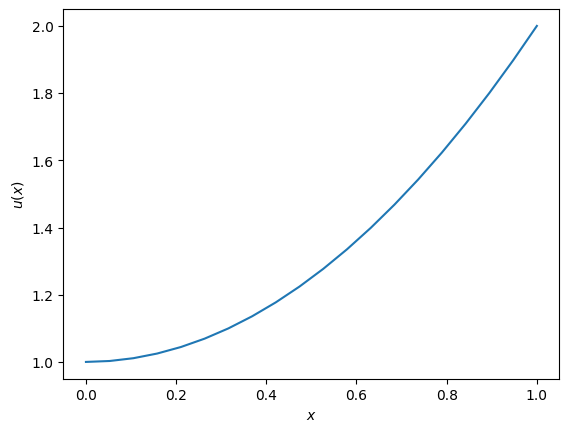

In [2]:
x = np.linspace(0, 1, 20)

def f_an(x):
    return 1 + x**2

an_sol = f_an(x)

plt.figure()
plt.plot(x, an_sol, '-')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')

Now, we set the parameters of the neural network: it has a structure with 1 input ($x$) and 1 output ($u(x)$), 5000 maximum training steps, 2 hidden layers with 16 neurons each, 20 samples and a target minimum loss value of $10^{-5}$.

In [3]:
inputs = 1
outputs = 1
hn_1 = 16
hn_2 = 16
steps = 0
max_steps = 5000
loss = 10
min_loss = 1e-5
log_each = 500
samples = 20
loss_values = []

The multilayer perceptron (MLP) structure is:

In [4]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    nn.Tanh(),
    nn.Linear(hn_1, hn_2),
    nn.Tanh(),
    nn.Linear(hn_2, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [5]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [ ]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    X = torch.rand((samples, 1), requires_grad=True)
    Y = mlp(X)
    dudx = computeGrads(Y, X)
    ode_loss = criterion(dudx, 2 * X)

    #initial condition
    X0 = torch.zeros(samples, 1)
    Y0 = mlp(X0)
    u0 = torch.ones(samples, 1)
    ic_loss = criterion(Y0, u0)

    optimizer.zero_grad()
    loss = ode_loss + ic_loss 
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} ic_loss {ic_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 0.84795 ic_loss 1.03741
Step:500| ode_loss 0.00543 ic_loss 0.00000
Step:1000| ode_loss 0.00207 ic_loss 0.00000
Step:1500| ode_loss 0.00200 ic_loss 0.00000
Step:2000| ode_loss 0.00122 ic_loss 0.00000
Step:2500| ode_loss 0.00028 ic_loss 0.00000
---Training Finished---
Training Duration: 2925 steps in 3.336 seconds


## Visualization

To visualize the model and compare results, we obtain the output of the trained model.

In [7]:
with torch.no_grad():
    X = torch.stack([torch.from_numpy(x).float()], axis=-1)
    Y = mlp(X)

result = Y.detach().numpy()

Finally, we plot the exact solution with the PINN approximation:

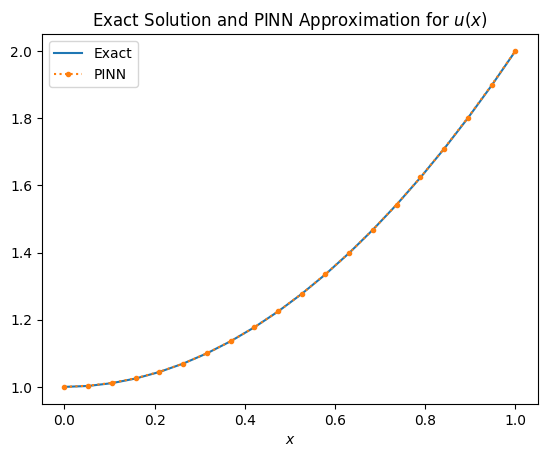

In [8]:
plt.figure()
plt.plot(x, an_sol, '-', label = 'Exact')
plt.plot(x, result, '.:', label = 'PINN')
plt.title('Exact Solution and PINN Approximation for $u(x)$')
plt.xlabel('$x$')
plt.legend()